In [1]:
import rosbag
import numpy as np
from std_msgs.msg import Int32, String
import matplotlib.pyplot as plt
import rosbag_pandas
import yaml

import warnings
import re
import subprocess
import types

import pandas as pd
import numpy as np

import rospy

In [17]:
#hard coded function of if statements to get out data we want from bag file
def bag2var(bag, topic):
    
    #create all potential empty lists
    translations_tf = []
    rotations_tf = []
    times_tf = []
    
    positions_vicon = []
    orientations_vicon = []
    times_vicon = []
    
    positions_joints = []
    torques_joints = []
    times_joints = []
    
    status_traj = []
    status_times_traj = []
    
    cycle_bools = []   
    cycle_times = []
    
    #iterate through, and fill vars based on topic name passed
    for topic, msg, t, in bag.read_messages(topics = [topic]):
        if '/tf' in topic:
            #/tf
            pos = np.array([msg.transforms[0].transform.translation.x, msg.transforms[0].transform.translation.y,
                           msg.transforms[0].transform.translation.z])
            rot = np.array([msg.transforms[0].transform.rotation.w, msg.transforms[0].transform.rotation.x,
                           msg.transforms[0].transform.rotation.y, msg.transforms[0].transform.rotation.z])
            time = msg.transforms[0].header.stamp.to_sec()
            
            translations_tf.append(pos)
            rotations_tf.append(rot)
            times_tf.append(time)
                           
        if '/vicon/' in topic:
            #/vicon
            pos = np.array([msg.position.x, msg.position.y, msg.position.z])
            rot = np.array([msg.orientation.w, msg.orientation.x, msg.orientation.y, 
                            msg.orientation.z])
            time = msg.header.stamp.to_sec()
            
            positions_vicon.append(pos)
            orientations_vicon.append(rot)
            times_vicon.append(time)
                           
        if '/robot/joint_states' in topic:
            #/joint_states
            if len(msg.name) > 2:  #heuristic to know that we're not getting fingers
                pos = np.array([msg.position])
                torq = np.array([msg.effort])
                time = msg.header.stamp.to_sec()

                positions_joints.append(pos)
                torques_joints.append(torq)
                times_joints.append(time)
                           
        if '/follow_joint_trajectory/status' in topic:
            #/status
            if len(msg.status_list) == 0:
                status_traj.append(0)
            else:
                status = msg.status_list[0].status
                status_traj.append(status)
            status_times_traj.append(msg.header.stamp.to_sec())
                           
        if '/board_pose/cycle_on' in topic:
            #/cycle_on bool
            cycle_bools.append(msg.data)
            
        if '/board_pose/cycle_time' in topic:
            #/cycle_time
            cycle_times.append(msg.data.to_sec())
            
    if '/tf' in topic:
        print "Returning translations, rotations, and timestamps for j1_base_link"
        return translations_tf, rotations_tf, times_tf
    if '/vicon/' in topic:
        #/vicon
        print "Returning positions, orientations, and timestamps for specified vicon rigid body"
        return positions_vicon, orientations_vicon, times_vicon
    if '/robot/joint_states' in topic:
        #/joint_states
        print "Returning positions and torques of all joints, indexed in order (see Baxter Wiki)"
        return positions_joints, torques_joints, times_joints
    if '/follow_joint_trajectory/status' in topic:
        #/status
        print "Returning trajectory status list with timestamps"
        return status_traj, status_times_traj
    if '/board_pose/cycle_on' in topic:
        #/cycle_on bool
        print "Returning cycle on/off flags"
        return cycle_bools
    if '/board_pose/cycle_time' in topic:
        #/cycle_time
        print "Returning cycle on/off times"
        return cycle_times

#get all data we're currently interested in out     
def allvars(bag):
    global j1_pos, j1_rot, j1_time
    global j2_pos, j2_rot, j2_time
    global j3_pos, j3_rot, j3_time
    global joint_angles, joint_torques, joint_times
    global traj_status, traj_time
    global cycle_on, cycle_time
    global tf_trans, tf_rot, tf_time
    
    print 'getting vicon data...'
    j1_pos, j1_rot, j1_time = bag2var(bag, '/vicon/j1_dim')
    j2_pos, j2_rot, j2_time = bag2var(bag, '/vicon/j2_dim')
    j3_pos, j3_rot, j3_time = bag2var(bag, '/vicon/j3_dim')
    
    print 'getting joint data...'
    joint_angles, joint_torques, joint_times = bag2var(bag, '/robot/joint_states')
    joint_angles = np.array(joint_angles).squeeze()
    joint_torqes = np.array(joint_torques).squeeze()
    
    print 'getting tf data...'
    tf_trans, tf_rot, tf_time = bag2var(bag, '/tf')
    
    print 'getting trajectory and cycle data...'
    traj_status, traj_time = bag2var(bag, '/robot/limb/right/follow_joint_trajectory/status')
    cycle_time = bag2var(bag, '/board_pose/cycle_time')

In [4]:
#load bag into memory as Bag object
bag = rosbag.Bag('/media/anthony/My Passport/Baxter_Bagfiles/one_joint_one_bag.bag')

In [5]:
#use yaml to make dictionary of info
info_dict = yaml.load(bag._get_yaml_info())

#index through to make a list of topic names
topic_list = []
for i in range(len(info_dict['topics'])):
    topic_list.append(info_dict['topics'][i]['topic'])
print topic_list

['/board_pose/cycle_on', '/board_pose/cycle_time', '/robot/joint_states', '/robot/limb/right/follow_joint_trajectory/status', '/tf', '/vicon/j1_dim', '/vicon/j2_dim', '/vicon/j3_dim']


In [31]:
#run allvars(bag) to get all global variables for plotting and analysis, or get individual variables

# allvars(bag)

# traj_status, traj_time = bag2var(bag, '/robot/limb/right/follow_joint_trajectory/status')
# cycle_time = bag2var(bag, '/board_pose/cycle_time')

joint_angles, joint_torques, joint_times = bag2var(bag, '/robot/joint_states')
joint_angles = np.array(joint_angles).squeeze()
joint_torques = np.array(joint_torques).squeeze()

# j1_pos, j1_rot, j1_time = bag2var(bag, '/vicon/j1_dim')
# j2_pos, j2_rot, j2_time = bag2var(bag, '/vicon/j2_dim')
# j3_pos, j3_rot, j3_time = bag2var(bag, '/vicon/j3_dim')

# tf_trans, tf_rot, tf_time = bag2var(bag, '/tf')

Returning positions and torques of all joints, indexed in order (see Baxter Wiki)


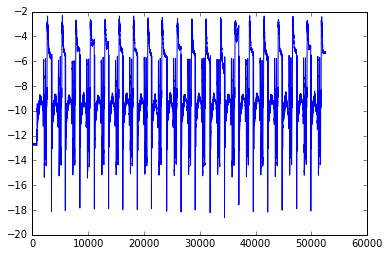

In [32]:
# np.array(joint_angles).squeeze().shape
# joint_angles[0].shape
# print(traj_status)
# plt.plot(traj_status)
# plt.show()
# plt.plot(traj_status)
# plt.show()
plt.plot(joint_torques[:,12])
plt.show()

In [35]:
df = rosbag_pandas.bag_to_dataframe('one_joint_one_bag.bag')

for c in df.columns:
    print c, df[c].min(), df[c].max()

board_pose_cycle_on__data 0.0 1.0
board_pose_cycle_time__data_nsecs 2024888.0 998908996.0
board_pose_cycle_time__data_secs 1519614495.0 1519614987.0
vicon_j1_dim__name inf j1_dim
vicon_j1_dim__occluded 0.0 0.0
vicon_j1_dim__orientation_w 0.18340788432213362 0.26593487019313355
vicon_j1_dim__orientation_x -0.41358237785046587 -0.2904739120812863
vicon_j1_dim__orientation_y 0.7327115869757205 0.7934371729290205
vicon_j1_dim__orientation_z -0.5026126083542558 -0.47041821785474425
vicon_j1_dim__position_x 0.4296318817023935 0.4427625007554507
vicon_j1_dim__position_y 0.9547649812222418 0.9641153797927864
vicon_j1_dim__position_z 1.310258345815758 1.310851362317449
vicon_j2_dim__name inf j2_dim
vicon_j2_dim__occluded 0.0 1.0
vicon_j2_dim__orientation_w 0.11351091397838865 1.0
vicon_j2_dim__orientation_x -0.338600225865392 0.6342907477234614
vicon_j2_dim__orientation_y -0.1977617850501419 0.8732190281873728
vicon_j2_dim__orientation_z -0.6130060103913137 0.0
vicon_j2_dim__position_x 0.0 0.48

In [16]:
# print df.columns
# print rosbag_pandas.get_bag_info('one_joint_one_bag.bag')
# print bag.read_messages(topics = '/tf')
num_msgs = 500
test_list = []
for topic, msg, t in bag.read_messages(topics = ['/robot/joint_states']):
    if num_msgs < 1:
        break
    num_msgs -= 1
    print msg

header: 
  seq: 20025593
  stamp: 
    secs: 1519613949
    nsecs: 959695372
  frame_id: ''
name: [head_nod, head_pan, left_e0, left_e1, left_s0, left_s1, left_w0, left_w1, left_w2,
  right_e0, right_e1, right_s0, right_s1, right_w0, right_w1, right_w2, torso_t0]
position: [0.0, -0.38656315854712425, -0.019941750242510378, 0.7198204847152304, 1.2586312364599819, 0.7727428218972772, 1.1332283070503495, 0.05445631796993219, 1.5589079756885518, 0.43373306777460074, 1.0730195611258468, 0.06787864986392955, -0.1729563338340804, -0.35434956200153056, 0.25502430598595005, -0.16988837225830958, -12.565987119160338]
velocity: [0.0, -0.005497787142750851, 0.02081305132612822, -0.0019634954081253035, 0.02042035224450316, -0.01021017612225158, 0.0035342917346255468, 0.029059732040254495, -0.0070685834692510935, 0.009424777959001457, 0.0023561944897503642, 0.018456856836377853, 0.0070685834692510935, -0.009424777959001457, 0.008639379795751335, -0.005497787142750851, 0.0]
effort: [0.0, 0.0, 0.644, 

effort: [0.0, 0.0, 0.736, -2.004, 0.124, -0.208, 0.304, 0.268, 0.448, 7.656, -9.48, -0.028, -12.66, 0.224, -1.024, 0.204, -20.48]
header: 
  seq: 20025723
  stamp: 
    secs: 1519613951
    nsecs: 259665710
  frame_id: ''
name: [head_nod, head_pan, left_e0, left_e1, left_s0, left_s1, left_w0, left_w1, left_w2,
  right_e0, right_e1, right_s0, right_s1, right_w0, right_w1, right_w2, torso_t0]
position: [0.0, -0.38656315854712425, -0.019941750242510378, 0.7190534943212877, 1.2582477412630106, 0.7727428218972772, 1.132844811853378, 0.05445631796993219, 1.558140985294609, 0.43373306777460074, 1.0730195611258468, 0.0674951546669582, -0.1729563338340804, -0.35434956200153056, 0.253873820395036, -0.16988837225830958, -12.565987119160338]
velocity: [0.0, 0.008246680714126275, -0.009817477040626518, -0.012566370612001944, 0.0, -0.006283185306000972, 0.00510508806112579, 0.011780972448751823, 0.005890486224375911, -0.013744467856877126, -0.010995574285501701, 0.003141592653000486, -0.012959069693

header: 
  seq: 20025877
  stamp: 
    secs: 1519613952
    nsecs: 799700107
  frame_id: ''
name: [head_nod, head_pan, left_e0, left_e1, left_s0, left_s1, left_w0, left_w1, left_w2,
  right_e0, right_e1, right_s0, right_s1, right_w0, right_w1, right_w2, torso_t0]
position: [0.0, -0.3869466537440956, -0.019941750242510378, 0.7202039799122018, 1.2586312364599819, 0.7712088411093918, 1.1332283070503495, 0.05445631796993219, 1.5589079756885518, 0.4345000581685434, 1.0734030563228183, 0.06787864986392955, -0.17333982903105175, -0.35319907641061654, 0.253873820395036, -0.16988837225830958, -12.565987119160338]
velocity: [0.0, 0.008246680714126275, 0.006675884387626033, -0.006283185306000972, -0.0047123889795007284, -0.00510508806112579, 0.0007853981632501215, 0.007461282550876154, 0.01021017612225158, 0.023954643979128706, -0.00039269908162506076, -0.018064157754752792, 0.008639379795751335, -0.0023561944897503642, -0.01060287520387664, -0.003926990816250607, 0.0]
effort: [0.0, 0.0, 0.672, -

In [ ]:
class Baxter_Data_Analysis(topics):
    def __init__(self):
        self.topics = topics
        self.date
        self.
    
    self.known_topics = ['/board_pose/cycle_on', '/board_pose/cycle_time', '/robot/joint_states',
                         '/robot/limb/right/follow_joint_trajectory/status',
                         '/tf', '/vicon/j1_dim', '/vicon/j2_dim', '/vicon/j3_dim']
